# RADI608: Classification and Regression Trees: Lecture

**ROMEN SAMUEL WABINA** | Student No. 6536435<br> 
PhD student, Data Science for Healthcare and Clinical Informatics <br>
Clinical Epidemiology and Biostatistics, Faculty of Medicine - Ramathibodi Hospital <br>
Mahidol University

## Notes
How does the SVM and Decision Trees solve the linearly separable problem?
- The SVM uses non-linear kernels, such as radial basis function and polynomial basis functions, to separate the data based on the decision boundary.
- The Decision Trees use hyperplanar graphs as partition thresholds to separate the data based on the calculated boundary. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import train_test_split

In [2]:
column_names = ["age", "sex", "cp", "trestbps", "chol", "fbs",
                "restecg", "thalach", "exang", "oldpeak", "slope",
                "ca", "thal", "num"]

# Drop rows with ambiguous values
df = pd.read_csv("../data/processed.cleveland.data", header = None, names = column_names)
for column in column_names:
    df = df[(df[column] != "?")].reset_index(drop=True)

# Convert to float
obj_df = df.select_dtypes(include=['object']).copy()
for column in column_names:
    df[column] = df[column].astype(float)

# Change column name and apply one-hot encoding
df['label'] = df['num'].apply(lambda x: 0 if x == 0 else 1)
df.drop('num', axis=1, inplace = True)

# Drop label column
X = df.drop('label', axis = 1).to_numpy()
y = df['label'].to_numpy().reshape(-1, 1)

FileNotFoundError: [Errno 2] No such file or directory: '../data/processed.cleveland.data'

In [ ]:
seed = 433 # Set random seed

train, remain = train_test_split(df, test_size = int(np.floor(0.30 * len(df.index))), 
                                stratify=df["label"], random_state = seed)

test, val = train_test_split(remain, test_size = int(np.floor(0.5 * len(remain.index))), 
                             stratify=remain["label"], random_state = seed)

print("Number of training samples is {}".format(len(train.index)))
print("Number of test samples is {}".format(len(test.index)))
print("Number of validate samples is {}".format(len(val.index)))

Number of training samples is 208
Number of test samples is 45
Number of validate samples is 44


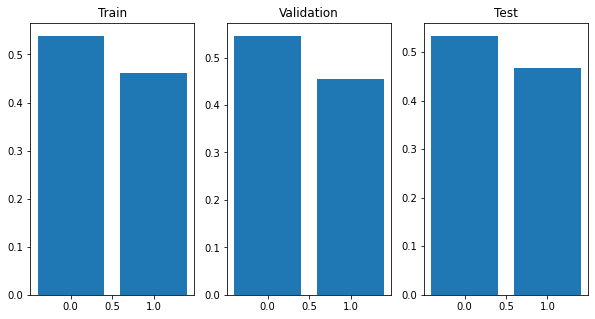

In [ ]:
train_dist = train.groupby("label").size().reset_index(name="#")
train_dist["%"] = train_dist["#"] / train_dist["#"].sum()

val_dist = val.groupby("label").size().reset_index(name="#")
val_dist["%"] = val_dist["#"] / val_dist["#"].sum()

test_dist = test.groupby("label").size().reset_index(name="#")
test_dist["%"] = test_dist["#"] / test_dist["#"].sum()

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
ax[0].bar(train_dist["label"], train_dist["%"])
ax[0].set_title("Train")
ax[1].bar(val_dist["label"], val_dist["%"])
ax[1].set_title("Validation")
ax[2].bar(test_dist["label"], test_dist["%"])
ax[2].set_title("Test")
plt.show()

In [ ]:
# Random search and GridSearch CV
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV

dt = DecisionTreeClassifier(random_state = seed, class_weight = "balanced")

np.random.seed(seed)
rand_depth = np.random.randint(low=1, high=5, size=10)
np.random.seed(seed)
rand_sample_split = np.random.randint(low=5, high=20, size=10)

rd_hparams = {"max_depth": rand_depth, "min_samples_split": rand_sample_split}
rand_tune = RandomizedSearchCV(dt, 
                               rd_hparams, 
                               random_state=seed, 
                               cv=[(train.index, val.index)], 
                               scoring="recall")

rand_search = rand_tune.fit(X, y)
rand_search.best_estimator_

DecisionTreeClassifier(class_weight='balanced', max_depth=3,
                       min_samples_split=12, random_state=433)

In [ ]:
from sklearn.model_selection import GridSearchCV

span_depth  = 1
span_sample = 4
grid_depth  = [rand_search.best_estimator_.max_depth + i for i in range(-span_depth, span_depth + 1)]
grid_sample = [rand_search.best_estimator_.min_samples_split + i for i in range(-span_sample, span_sample + 1)]

gd_hparams  = {"max_depth": grid_depth, "min_samples_split": grid_sample}
grid_tune   = GridSearchCV(dt, gd_hparams, cv = [(train.index, val.index)], scoring = "recall")
grid_search = grid_tune.fit(X, y)
grid_search.best_estimator_

DecisionTreeClassifier(class_weight='balanced', max_depth=3,
                       min_samples_split=8, random_state=433)

In [ ]:
prob_test = grid_search.best_estimator_.predict_proba(X[test.index])

# Threshold Calibration
from sklearn.metrics import roc_curve

prob_trian = grid_search.best_estimator_.predict_proba(X[train.index])

fpr, tpr, thresholds = roc_curve(y_true=y[train.index], y_score = prob_trian[:, 1], pos_label = 1)

idx = np.argmax(tpr - fpr)

optimal_threshold = thresholds[idx]
print("The optimal threshold is {}".format(optimal_threshold))

The optimal threshold is 0.6549118387909321


In [10]:
yhat = (prob_test[:, 1] >= optimal_threshold.astype(int))

from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, f1_score, roc_auc_score

cmat = confusion_matrix(y[test.index], yhat)
print(cmat)

print("Precision is {}".format(round(cmat[1, 1] / (cmat[1, 1] + cmat[0, 1]), 3)))
print("Recall is {}".format(round(cmat[1, 1] / (cmat[1, 1] + cmat[1, 0]), 3)))
print("Accuracy is {}".format(round((cmat[1, 1] + cmat[0, 0]) / cmat.sum(), 3)))
P = cmat[1, 1] / (cmat[1, 1] + cmat[0, 1])
R = cmat[1, 1] / (cmat[1, 1] + cmat[1, 0])
print("F1 is {}".format(round(2 * P * R / (P + R), 3)))


[[ 0 24]
 [ 0 21]]
Precision is 0.467
Recall is 1.0
Accuracy is 0.467
F1 is 0.636


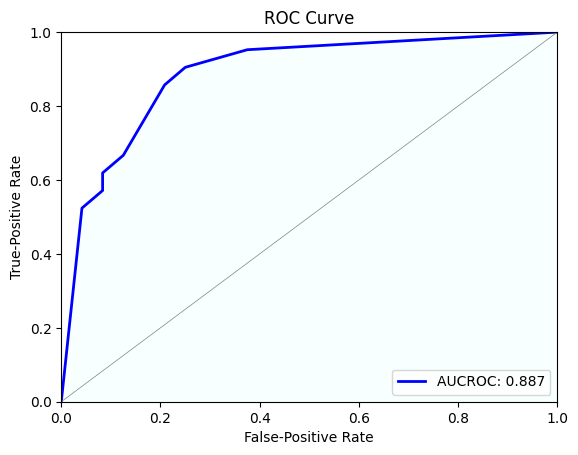

In [12]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc

aucroc = roc_auc_score(y_true=y[test.index], y_score=prob_test[:, 1])
fpr, tpr, thresholds = roc_curve(y_true=y[test.index], y_score=prob_test[:, 1], pos_label=1)

plt.style.use("default")
plt.plot(fpr, tpr, color="blue", linewidth=2, label="AUCROC: {}".format(round(aucroc, 3)))
plt.plot([0, 1], [0, 1], color="gray", linewidth=0.5)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("False-Positive Rate")
plt.ylabel("True-Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="best")
plt.fill_between(fpr, tpr, color="azure", alpha=0.5)
plt.savefig("../images/roc_dt.svg", format="svg")


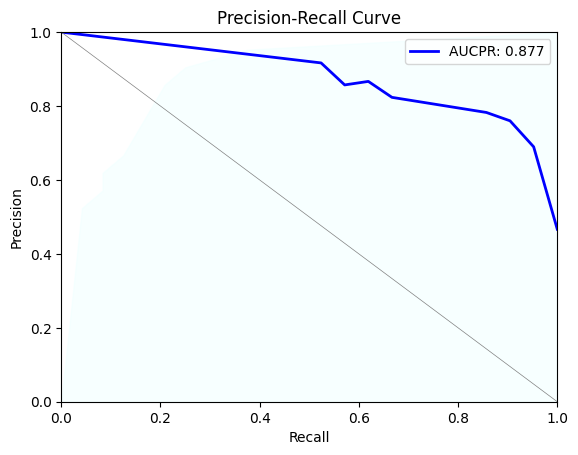

In [187]:
p, r, t = precision_recall_curve(y_true=y[test.index], probas_pred=prob_test[:, 1], pos_label=1)
aucpr = auc(r, p)
plt.style.use("default")
plt.plot(r, p, color="blue", linewidth=2, label="AUCPR: {}".format(round(aucpr, 3)))
plt.plot([1, 0], [0, 1], color="gray", linewidth=0.5)
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend(loc="best")
plt.fill_between(fpr, tpr, color="azure", alpha=0.5)
plt.savefig("../images/pr_dt.svg", format="svg")


[Text(775.0, 336.875, 'thal <= 4.5\ngini = 0.5\nsamples = 297\nvalue = [148.5, 148.5]\nclass = y[1]'),
 Text(387.5, 240.625, 'ca <= 0.5\ngini = 0.379\nsamples = 164\nvalue = [117.872, 40.106]\nclass = y[0]'),
 Text(193.75, 144.375, 'trestbps <= 157.0\ngini = 0.226\nsamples = 115\nvalue = [94.669, 14.091]\nclass = y[0]'),
 Text(96.875, 48.125, 'gini = 0.172\nsamples = 109\nvalue = [92.812, 9.755]\nclass = y[0]'),
 Text(290.625, 48.125, 'gini = 0.42\nsamples = 6\nvalue = [1.856, 4.336]\nclass = y[1]'),
 Text(581.25, 144.375, 'cp <= 3.5\ngini = 0.498\nsamples = 49\nvalue = [23.203, 26.015]\nclass = y[1]'),
 Text(484.375, 48.125, 'gini = 0.395\nsamples = 29\nvalue = [20.419, 7.588]\nclass = y[0]'),
 Text(678.125, 48.125, 'gini = 0.228\nsamples = 20\nvalue = [2.784, 18.427]\nclass = y[1]'),
 Text(1162.5, 240.625, 'cp <= 3.5\ngini = 0.344\nsamples = 133\nvalue = [30.628, 108.394]\nclass = y[1]'),
 Text(968.75, 144.375, 'ca <= 0.5\ngini = 0.499\nsamples = 44\nvalue = [21.347, 22.763]\nclass =

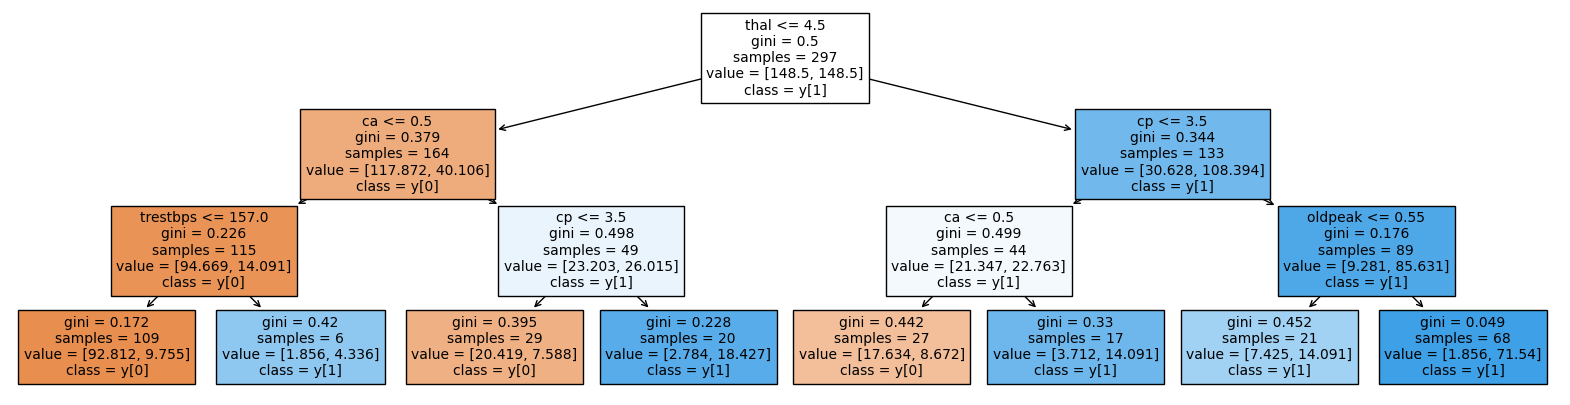

In [188]:
from sklearn import tree

plt.figure(figsize=(20,5))
tree.plot_tree(grid_search.best_estimator_, fontsize=10, feature_names=df.columns[0:-1], class_names=True, filled=True)


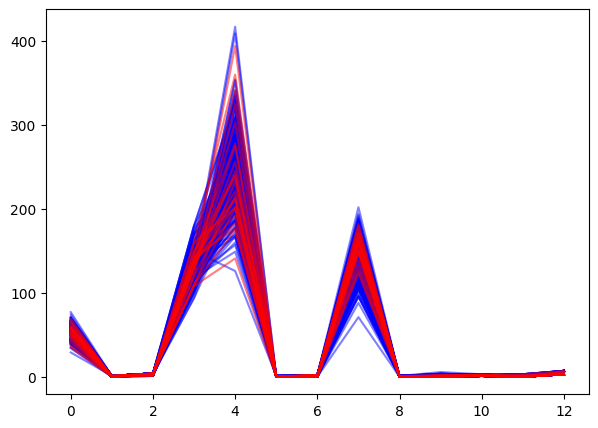

In [194]:
# Analyzing Misclassified Samples
# We should start from hypothesis 
# One of the possible reaons is abot coverage in training class 



# Out of Distribution
test_samples = test.copy()
test_samples["yhat"] = yhat
missclf = test_samples[test_samples["label"] != test_samples["yhat"]].reset_index()

def error_types(label, yhat):
    if (label == 1) & (yhat == 0):
        return "fn"
    elif (label == 0) & (yhat == 1):
        return "fp"
    else:
        return "correct"


missclf["error"] = missclf.apply(lambda x: error_types(x["label"], x["yhat"]), axis=1)
missclf

figure, axis = plt.subplots(figsize=(7, 5))

for i in train.index:
    xlabel = df.columns[0:-1]
    xval = range(len(xlabel))
    yval = train.loc[i, xlabel]
    axis.plot(xval, yval, alpha=0.5, color="blue")
    
for i in missclf.index:
    xlabel = df.columns[0:-1]
    xval = range(len(xlabel))
    yval = missclf.loc[i, xlabel]
    axis.plot(xval, yval, alpha=0.5, color="red")


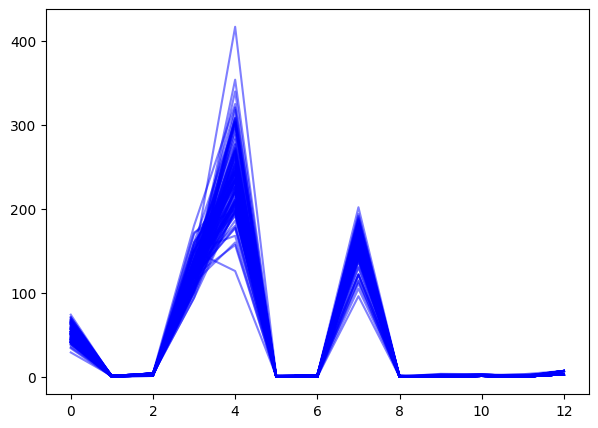

In [195]:
fn = missclf[missclf["error"] == "fn"].reset_index(drop=True)
neg_samples = train[train["label"] == 0].reset_index()


figure, axis = plt.subplots(figsize=(7, 5))

for i in neg_samples.index:
    xlabel = df.columns[0:-1]
    xval = range(len(xlabel))
    yval = neg_samples.loc[i, xlabel]
    axis.plot(xval, yval, alpha=0.5, color="blue")
    
for i in fn.index:
    xlabel = df.columns[0:-1]
    xval = range(len(xlabel))
    yval = fn.loc[i, xlabel]
    axis.plot(xval, yval, alpha=0.5, color="red")


In [151]:
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeClassifier

model = DecisionTreeClassifier(criterion = 'entropy').fit(X, y)

xx, yy = np.meshgrid(np.linspace(-5, 5, num = 200), np.linspace(-2, 11, num = 200))
# Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

# def plot_tree(model, X, y):
#     plt.grid()
#     plt.scatter(X[:, 0], X[:, 1], c = y, s = 30)
#     xx, yy = np.meshgrid(np.linspace(-5, 5, num=200), np.linspace(-2, 11, num=200))
#     Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
#     n_classes = len(set(y))
#     contours = plt.contourf(xx, yy, Z, alpha=0.2)
    
# plot_tree(model, X, y)
xx.shape

(200, 200)

In [72]:
def find_split(X, y, n_classes):
    n_samples, n_features = X.shape
    
    feature_ix, threshold = None, None
    sample_per_class_parent = [np.sum(y == c) for c in range(n_classes)]
    best_gini = 1.0 - sum((n / n_samples) ** 2 for n in sample_per_class_parent)

    for feature in range(n_features):
        sample_sorted = sorted(X[:, feature])
        y_sorted = sorted(y)
        
        sample_per_class_left  = [0] * n_classes        
        sample_per_class_right = sample_per_class_parent.copy()
        
        for i in range(1, n_samples): 
            c = y_sorted[i - 1]
            sample_per_class_left[c]  += 1
            sample_per_class_right[c] -= 1
            
            gini_left  = 1.0 - sum((sample_per_class_left[x] / i) ** 2 for x in range(n_classes)) 
            gini_right = 1.0 - sum((sample_per_class_right[x] / (n_samples - i)) ** 2 for x in range(n_classes))
            weighted_gini = ((i / n_samples) * gini_left) + ( (n_samples - i) /n_samples) * gini_right

            if sample_sorted[i] == sample_sorted[i - 1]:
                continue

            if weighted_gini < best_gini:
                best_gini = weighted_gini
                feature_ix = feature
                threshold = (sample_sorted[i] + sample_sorted[i - 1]) / 2
    return feature_ix, threshold

In [73]:
X = np.array([[2],[3],[10],[19]])
y = np.array([0, 0, 1, 1])
feature, threshold = find_split(X, y, len(set(y)))

print("Best feature used for split: ",   feature)
print("Best threshold used for split: ", threshold)

Best feature used for split:  0
Best threshold used for split:  6.5


In [74]:
class Node:
    def __init__(self, gini, num_samples, num_samples_per_class, predicted_class):
        self.gini = gini
        self.num_samples = num_samples
        self.num_samples_per_class = num_samples_per_class
        self.predicted_class = predicted_class
        self.feature_index = 0
        self.threshold = 0
        self.left = None
        self.right = None

def fit(Xtrain, ytrain, n_classes, max_depth = 3, depth=0):
    n_samples, n_features = Xtrain.shape
    num_samples_per_class = [np.sum(ytrain == c) for c in range(n_classes)]
    predicted_class = np.argmax(num_samples_per_class)
    
    node = Node(
        gini = 1 - sum((np.sum(y == c) / n_samples) ** 2 for c in range(n_classes)),
        predicted_class=predicted_class,
        num_samples = ytrain.size,
        num_samples_per_class = num_samples_per_class,
        )
        
    if depth < max_depth:
        feature, threshold = find_split(Xtrain, ytrain, n_classes)
        if feature is not None:
            indices_left = X[:, feature] < threshold
            X_left, y_left   = X[indices_left], y[indices_left]            
            X_right, y_right = X[~indices_left], y[~indices_left]
            node.feature_index = feature
            node.threshold = threshold
            node.left = fit(X_left, y_left, max_depth, depth+1)
            node.right = fit(X_right, y_right, max_depth, depth+1)
    return node

def predict(sample, tree):
    while tree.left:
        if sample[tree.feature_index] < tree.threshold:
            tree = tree.left
        else:
            tree = tree.right
    return tree.predicted_class

In [75]:
Xtrain = np.array([[2, 5],[3, 5],[10, 5],[19, 5]])
ytrain = np.array([0, 0, 1, 1])
Xtest = np.array(([[4, 6],[6, 9],[9, 2],[12, 8]]))
ytest = np.array([0, 0, 1, 1])

tree = fit(Xtrain, ytrain, n_classes=len(set(ytrain)), max_depth = 3, depth=0,)
pred = [predict(x, tree) for x in Xtest]

print("Tree feature ind: ", tree.feature_index)
print("Tree threshold: ", tree.threshold)
print("Pred: ",  np.array(pred))
print("ytest: ", ytest)

Tree feature ind:  0
Tree threshold:  6.5
Pred:  [0 0 1 1]
ytest:  [0 0 1 1]


## SKLEARN approach

(300, 2)
(300,)


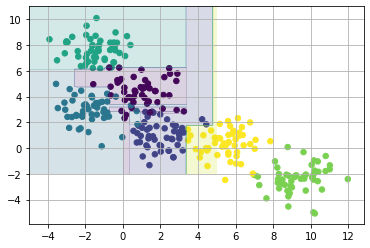

In [86]:
from sklearn.datasets import make_blobs
from sklearn.tree import DecisionTreeClassifier

X, y = make_blobs(n_samples = 300, centers = 6, random_state = 0, cluster_std = 1.0)
print(X.shape)
print(y.shape)

model = DecisionTreeClassifier(criterion = 'entropy').fit(X, y)

xx, yy = np.meshgrid(np.linspace(-5, 5, num=200), np.linspace(-2, 11, num=200))
Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

def plot_tree(model, X, y):
    plt.grid()
    plt.scatter(X[:, 0], X[:, 1], c = y, s = 30)
    xx, yy = np.meshgrid(np.linspace(-5, 5, num=200), np.linspace(-2, 11, num=200))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
    
    n_classes = len(set(y))
    contours = plt.contourf(xx, yy, Z, alpha=0.2)
    
plot_tree(model, X, y)